In [527]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as pyplot

In [528]:
colab_path = 'ScadaData.txt'
local_path = 'C:\\Users\\hanna\\Desktop\\data\\ScadaData.txt'

scada_data = pd.read_csv(local_path, delimiter='\t',  parse_dates=True)
scada_data['dtTimeStamp'] = pd.to_datetime(scada_data['dtTimeStamp'])
data = scada_data[['dtTimeStamp','WindSpeedMean','WindDirectionMean', 'intObjectId']].groupby('dtTimeStamp').mean()[['WindSpeedMean','WindDirectionMean']][0:2000]
print(data.tail(100))

                     WindSpeedMean  WindDirectionMean
dtTimeStamp                                          
2019-08-14 04:40:00       3.011111         132.811111
2019-08-14 04:50:00       2.996296         134.166667
2019-08-14 05:00:00       2.981481         135.488889
2019-08-14 05:10:00       2.925926         138.229630
2019-08-14 05:20:00       2.692593         140.996296
...                            ...                ...
2019-08-14 20:30:00       4.744444         192.011111
2019-08-14 20:40:00       4.588889         190.214815
2019-08-14 20:50:00       4.725926         189.303704
2019-08-14 21:00:00       5.211111         193.203704
2019-08-14 21:10:00       5.344444         195.440741

[100 rows x 2 columns]


In [529]:
from statsmodels.tsa.arima_model import ARIMA
import datetime as dt
import math

def get_predictions(data, column_name):
    X = data[[column_name]]
    size = int(len(X) * 0.1)
    train, test = X[0:size], X[size:len(X)]
    history = train
    predictions = pd.DataFrame(index=test.index, columns=[column_name])
    for i, row in test.iterrows():
        model = ARIMA(history, order=(1,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0].flatten()[0]
        predictions.loc[i][column_name] = yhat
        history.loc[i] = row[column_name]

    return predictions

data['WindDirectionMean'] = data['WindDirectionMean'].apply(math.radians)
wind_speed_predictions = get_predictions(data, 'WindSpeedMean')
wind_direction_predictions = get_predictions(data, 'WindDirectionMean')

data['WindDirectionMean'] = data['WindDirectionMean'].apply(math.degrees)

wind_direction_predictions['WindDirectionMean'] = wind_direction_predictions['WindDirectionMean'].apply(math.degrees)
all_predictions = pd.concat([wind_speed_predictions, wind_direction_predictions], axis='index')
print(all_predictions)


                    WindSpeedMean  WindDirectionMean
dtTimeStamp                                         
2019-08-02 09:20:00       3.06628                NaN
2019-08-02 09:30:00       3.27731                NaN
2019-08-02 09:40:00        3.1605                NaN
2019-08-02 09:50:00       3.22049                NaN
2019-08-02 10:00:00       3.57613                NaN
...                           ...                ...
2019-08-14 20:30:00           NaN         190.722831
2019-08-14 20:40:00           NaN         192.281410
2019-08-14 20:50:00           NaN         189.993481
2019-08-14 21:00:00           NaN         189.218047
2019-08-14 21:10:00           NaN         193.859336

[3600 rows x 2 columns]


In [530]:
all_predictions = pd.concat([wind_speed_predictions, wind_direction_predictions], axis=1)
print(all_predictions)

                    WindSpeedMean  WindDirectionMean
dtTimeStamp                                         
2019-08-02 09:20:00       3.06628         305.303084
2019-08-02 09:30:00       3.27731         325.686014
2019-08-02 09:40:00        3.1605         291.545736
2019-08-02 09:50:00       3.22049         247.450074
2019-08-02 10:00:00       3.57613         241.960998
...                           ...                ...
2019-08-14 20:30:00       5.06187         190.722831
2019-08-14 20:40:00       4.67499         192.281410
2019-08-14 20:50:00       4.55319         189.993481
2019-08-14 21:00:00       4.75884         189.218047
2019-08-14 21:10:00       5.32589         193.859336

[1800 rows x 2 columns]


In [531]:
import os
import sys

new_path = r'C:\Users\hanna\Documents\GitHub\dissertation'
sys.path.append(new_path)

from api.noise_campaign.histogram import Histogram

In [532]:
h = Histogram(3, 12, 1, 12)
wind_speed_bins = h.get_wind_speed_bins()
wind_direction_bins = h.get_wind_direction_bins()

In [533]:
wind_speed_bins

{3: [2.5, 3.5],
 4: [3.5, 4.5],
 5: [4.5, 5.5],
 6: [5.5, 6.5],
 7: [6.5, 7.5],
 8: [7.5, 8.5],
 9: [8.5, 9.5],
 10: [9.5, 10.5],
 11: [10.5, 11.5],
 12: [11.5, 12.5],
 13: [12.5, 13.5],
 14: [13.5, 14.5]}

In [534]:
wind_direction_bins

{0.0: [-15.0, 15.0],
 30.0: [15.0, 45.0],
 60.0: [45.0, 75.0],
 90.0: [75.0, 105.0],
 120.0: [105.0, 135.0],
 150.0: [135.0, 165.0],
 180.0: [165.0, 195.0],
 210.0: [195.0, 225.0],
 240.0: [225.0, 255.0],
 270.0: [255.0, 285.0],
 300.0: [285.0, 315.0],
 330.0: [315.0, 345.0]}

In [535]:
import itertools
bins = [list(itertools.chain(*wind_speed_bins.values())), list(itertools.chain(*wind_direction_bins.values()))]

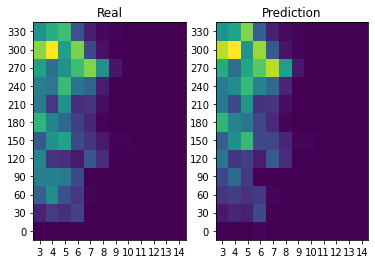

In [536]:
x_raw = data['WindSpeedMean']
y_raw = data['WindDirectionMean']
x_pred = all_predictions['WindSpeedMean']
y_pred = all_predictions['WindDirectionMean']

fig, axes = pyplot.subplots(1, 2)
axes[0].hist2d(x_raw, y_raw, bins=bins)
axes[0].title.set_text('Real')
axes[1].hist2d(x_pred, y_pred, bins=bins)
axes[1].title.set_text('Prediction')

axes[0].set_xticks(list(wind_speed_bins.keys()))
axes[0].set_yticks(list(wind_direction_bins.keys()))

axes[1].set_xticks(list(wind_speed_bins.keys()))
axes[1].set_yticks(list(wind_direction_bins.keys()))
       
pyplot.show()

In [537]:
data["SpeedBin"] = data['WindSpeedMean'].apply(h.get_wind_speed_bin)
data["DirectionBin"] = data['WindDirectionMean'].apply(h.get_wind_direction_bin)

all_predictions["PredictedSpeedBin"] = all_predictions['WindSpeedMean'].apply(h.get_wind_speed_bin)
all_predictions["PredictedDirectionBin"] = all_predictions['WindDirectionMean'].apply(h.get_wind_direction_bin)

In [538]:
comp = pd.DataFrame()

comp['WindSpeedMean'] = data['WindSpeedMean']
comp['WindDirectionMean'] = data['WindDirectionMean']

comp['PredictedWindSpeedMean'] = all_predictions['WindSpeedMean']
comp['PredictedWindDirectionMean'] = all_predictions['WindDirectionMean']

comp['SpeedBin'] = data['SpeedBin']
comp['DirectionBin'] = data['DirectionBin']
comp['PredictedSpeedBin'] = all_predictions["PredictedSpeedBin"] 
comp['PredictedDirectionBin'] = all_predictions["PredictedDirectionBin"] 

comp.dropna(inplace=True)
comp['SpeedBinEqual'] = comp['SpeedBin'] == comp["PredictedSpeedBin"]
comp['DirectionBinEqual'] = comp['DirectionBin'] == comp["PredictedDirectionBin"]

comp.shape

(1576, 10)

In [539]:
wrong = comp.query('DirectionBinEqual == False or SpeedBinEqual == False')

error = len(wrong) / comp.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

from sklearn.metrics import mean_squared_error
import math 

print("\nMSE for speed")
print(mean_squared_error(comp['WindSpeedMean'], comp['PredictedWindSpeedMean']))

print("\nMSE for direction")
print(math.degrees(mean_squared_error(comp['WindDirectionMean'].apply(math.radians), comp['PredictedWindDirectionMean'].apply(math.radians))))

Percentage of bins wrong:
37.119289340101524

MSE for speed
0.13904607799676055

MSE for direction
4.676883464682488


In [540]:
import numpy as np
comp['SpeedBinDifference'] = comp["PredictedSpeedBin"]- comp['SpeedBin']
comp['DirectionBinDifference'] = (comp['DirectionBin'] - comp["PredictedDirectionBin"]) / 30

In [541]:
comp.query('DirectionBinEqual == False or SpeedBinEqual == False')

,WindSpeedMean,WindDirectionMean,PredictedWindSpeedMean,PredictedWindDirectionMean,SpeedBin,DirectionBin,PredictedSpeedBin,PredictedDirectionBin,SpeedBinEqual,DirectionBinEqual,SpeedBinDifference,DirectionBinDifference
dtTimeStamp,,,,,,,,,,,,
2019-08-02 09:20:00,3.229630,321.237037,3.06628,305.303084,3.0,330.0,3.0,300.0,True,False,0.0,1.0
2019-08-02 09:30:00,3.177778,295.111111,3.27731,325.686014,3.0,300.0,3.0,330.0,True,False,0.0,-1.0
2019-08-02 09:40:00,3.207407,253.970370,3.1605,291.545736,3.0,240.0,3.0,300.0,True,False,0.0,-2.0
2019-08-02 10:00:00,3.418519,218.237037,3.57613,241.960998,3.0,210.0,4.0,240.0,False,False,1.0,-1.0
2019-08-02 10:10:00,2.781481,156.262963,3.40073,214.398796,3.0,150.0,3.0,210.0,True,False,0.0,-2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-14 17:30:00,3.533333,181.555556,3.40321,175.403373,4.0,180.0,3.0,180.0,False,True,-1.0,0.0
2019-08-14 17:40:00,3.462963,179.270370,3.5606,182.282517,3.0,180.0,4.0,180.0,False,True,1.0,0.0
2019-08-14 17:50:00,3.659259,175.248148,3.4468,178.969739,4.0,180.0,3.0,180.0,False,True,-1.0,0.0


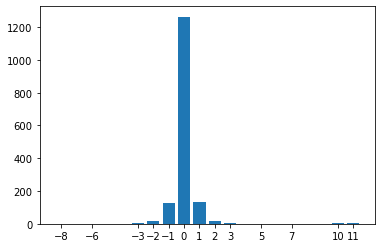

In [542]:
import matplotlib.pyplot as plt

labels, counts = np.unique(comp["DirectionBinDifference"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

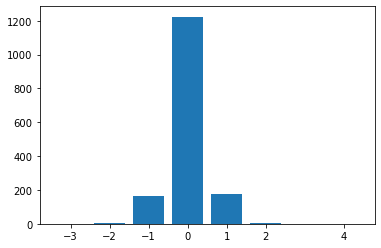

In [543]:
labels, counts = np.unique(comp["SpeedBinDifference"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

In [544]:
wrong = comp.query('SpeedBinDifference in [-1,1]')

error = len(wrong) / comp.shape[0] * 100

print("Percentage of bins wrong:")
print(error)


Percentage of bins wrong:
21.63705583756345


In [545]:
wrong = comp.query('DirectionBinDifference in [-1,1]')

error = len(wrong) / comp.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
16.687817258883246


In [546]:
wrong = comp.query('DirectionBinDifference != 0 or SpeedBinDifference != 0')

error = len(wrong) / comp.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
37.119289340101524


In [547]:
wrong = comp.query('SpeedBinDifference in [-1,1]')
len(wrong)

341

In [548]:
wrong = comp.query('DirectionBinDifference in [-1,1]')
len(wrong)

263

In [549]:
comp.shape[0]

1576

In [550]:
wrong = comp.query('DirectionBinDifference == -1')
len(wrong) / comp.shape[0] * 100

8.121827411167512

In [551]:
wrong = comp.query('DirectionBinDifference == 1')
len(wrong) / comp.shape[0] * 100

8.565989847715736

In [552]:
wrong = comp.query('SpeedBinDifference == -1')
len(wrong) / comp.shape[0] * 100

10.406091370558377

In [553]:
wrong = comp.query('SpeedBinDifference == 1')
len(wrong) / comp.shape[0] * 100

11.230964467005077

In [554]:
wrong = comp.query('SpeedBinDifference != 0')

error = len(wrong) / comp.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
22.33502538071066


In [555]:
wrong = comp.query('DirectionBinDifference != 0')

error = len(wrong) / comp.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
19.796954314720814


In [556]:
from random import randint
from statistics import mean

def correct_wind_speed_errors(predicted_bin):
#     value_1 = randint(0, 100)
#     if value_1 <= 12:
#         predicted_bin += 1
    return predicted_bin


def correct_wind_direction_errors(predicted_bin):
    value_1 = randint(0, 100)
    if value_1 <= 12:
        value_2 = randint(0,1)
        if value_2 == 1:
            predicted_bin = math.degrees(math.radians(predicted_bin) + math.radians(60))
        else:
            predicted_bin = math.degrees(math.radians(predicted_bin) - math.radians(60))
            
    return predicted_bin

all_predictions['CorrectedPredictedSpeedBin'] = all_predictions['PredictedSpeedBin'].apply(correct_wind_speed_errors)
all_predictions['CorrectedPredictedDirectionBin'] = all_predictions['PredictedDirectionBin'].apply(correct_wind_direction_errors)

In [557]:
comp_2 = pd.DataFrame()

comp_2['WindSpeedMean'] = data['WindSpeedMean']
comp_2['WindDirectionMean'] = data['WindDirectionMean']

comp_2['PredictedWindSpeedMean'] = all_predictions['WindSpeedMean']
comp_2['PredictedWindDirectionMean'] = all_predictions['WindDirectionMean']

comp_2['SpeedBin'] = data['SpeedBin']
comp_2['DirectionBin'] = data['DirectionBin']
comp_2['PredictedSpeedBin'] = all_predictions["PredictedSpeedBin"] 
comp_2['PredictedDirectionBin'] = all_predictions["PredictedDirectionBin"] 

comp_2.dropna(inplace=True)
comp_2['SpeedBinEqual'] = comp_2['SpeedBin'] == comp_2["PredictedSpeedBin"]
comp_2['DirectionBinEqual'] = comp_2['DirectionBin'] == comp_2["PredictedDirectionBin"]

comp_2['SpeedBinDifference'] = comp_2["PredictedSpeedBin"] - comp_2['SpeedBin']
comp_2['DirectionBinDifference'] = (comp_2['DirectionBin'] - comp_2["PredictedDirectionBin"]) / 30


comp_2['SpeedDifference'] = data['WindSpeedMean'] - all_predictions['WindSpeedMean']
comp_2['DirectionDifference'] = (data['WindDirectionMean'].apply(math.radians) - all_predictions['WindDirectionMean'].apply(math.radians)).apply(math.degrees)


comp_2.query('DirectionBinEqual == False or SpeedBinEqual == False')

,WindSpeedMean,WindDirectionMean,PredictedWindSpeedMean,PredictedWindDirectionMean,SpeedBin,DirectionBin,PredictedSpeedBin,PredictedDirectionBin,SpeedBinEqual,DirectionBinEqual,SpeedBinDifference,DirectionBinDifference,SpeedDifference,DirectionDifference
dtTimeStamp,,,,,,,,,,,,,,
2019-08-02 09:20:00,3.229630,321.237037,3.06628,305.303084,3.0,330.0,3.0,300.0,True,False,0.0,1.0,0.163352,15.933953
2019-08-02 09:30:00,3.177778,295.111111,3.27731,325.686014,3.0,300.0,3.0,330.0,True,False,0.0,-1.0,-0.0995349,-30.574903
2019-08-02 09:40:00,3.207407,253.970370,3.1605,291.545736,3.0,240.0,3.0,300.0,True,False,0.0,-2.0,0.046904,-37.575366
2019-08-02 10:00:00,3.418519,218.237037,3.57613,241.960998,3.0,210.0,4.0,240.0,False,False,1.0,-1.0,-0.157614,-23.723961
2019-08-02 10:10:00,2.781481,156.262963,3.40073,214.398796,3.0,150.0,3.0,210.0,True,False,0.0,-2.0,-0.619251,-58.135833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-08-14 17:30:00,3.533333,181.555556,3.40321,175.403373,4.0,180.0,3.0,180.0,False,True,-1.0,0.0,0.130127,6.152183
2019-08-14 17:40:00,3.462963,179.270370,3.5606,182.282517,3.0,180.0,4.0,180.0,False,True,1.0,0.0,-0.0976402,-3.012147
2019-08-14 17:50:00,3.659259,175.248148,3.4468,178.969739,4.0,180.0,3.0,180.0,False,True,-1.0,0.0,0.212455,-3.721591


In [558]:
print(mean(comp_2["DirectionBinDifference"]))

print(mean(comp_2["SpeedBinDifference"]))


print(max(comp_2["SpeedBinDifference"]))

print(max(comp_2["DirectionBinDifference"]))

print(min(comp_2["SpeedBinDifference"]))

print(min(comp_2["DirectionBinDifference"]))

0.038705583756345176
0.005076142131979695
4.0
11.0
-3.0
-8.0


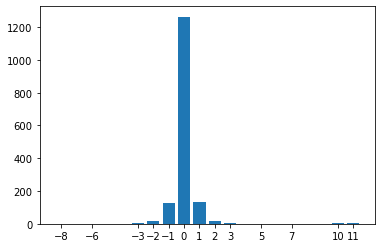

In [559]:
labels, counts = np.unique(comp_2["DirectionBinDifference"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

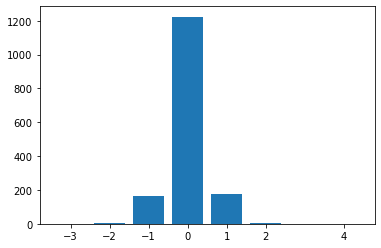

In [560]:
labels, counts = np.unique(comp_2["SpeedBinDifference"], return_counts=True)
plt.bar(labels, counts, align='center')
plt.gca().set_xticks(labels)
plt.show()

In [561]:
wrong = comp_2.query('SpeedBinDifference != 0')

error = len(wrong) / comp_2.shape[0] * 100

print("Percentage of bins wrong:")
print(error)


Percentage of bins wrong:
22.33502538071066


In [562]:
wrong = comp_2.query('SpeedBinDifference != 0')
len(wrong)

352

In [563]:
wrong = comp_2.query('DirectionBinDifference != 0 or SpeedBinDifference != 0')

error = len(wrong) / comp_2.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
37.119289340101524


Text(0.5, 1.0, 'Real vs Predictions')

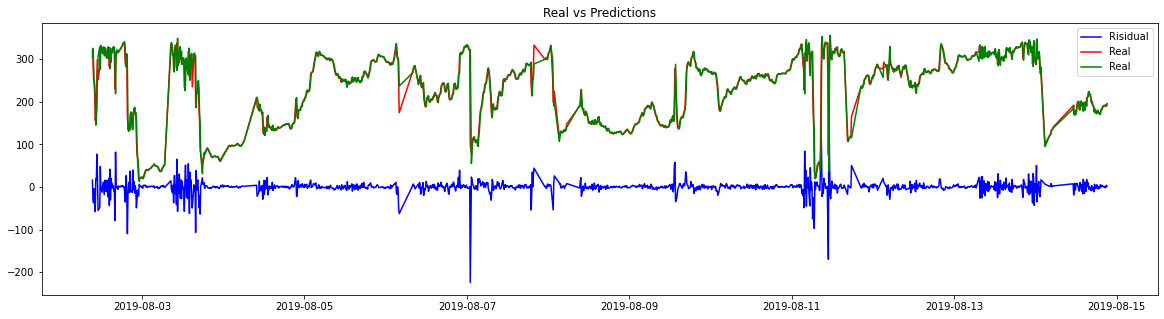

In [564]:
plt.figure(figsize=(20,5))
plt.plot(comp_2["DirectionDifference"], color='blue', label='Risidual')
plt.plot(comp_2['WindDirectionMean'], color='red', label='Real')
plt.plot(comp_2['PredictedWindDirectionMean'], color='green', label='Real')
plt.legend(loc='best')
plt.title('Real vs Predictions')

Text(0.5, 1.0, 'Real vs Predictions')

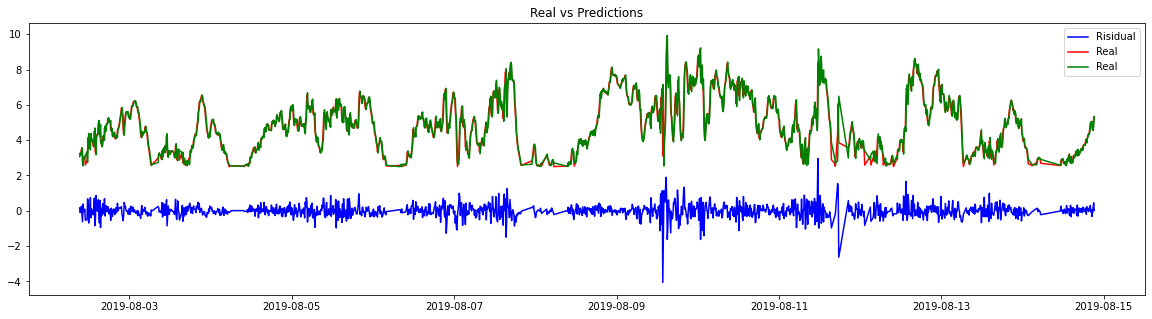

In [565]:
plt.figure(figsize=(20,5))
plt.plot(comp_2["SpeedDifference"], color='blue', label='Risidual')
plt.plot(comp_2['WindSpeedMean'], color='red', label='Real')
plt.plot(comp_2['PredictedWindSpeedMean'], color='green', label='Real')
plt.legend(loc='best')
plt.title('Real vs Predictions')

<AxesSubplot:>

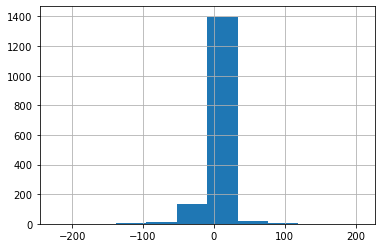

In [566]:
comp_2["DirectionDifference"].hist()


<AxesSubplot:>

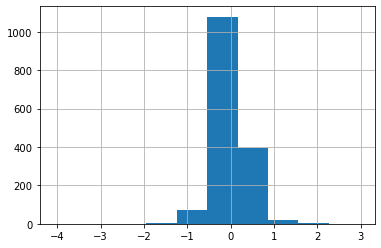

In [567]:
comp_2["SpeedDifference"].hist()

In [568]:
wrong = comp_2.query('DirectionBinDifference not in [-1,1,0]')

error = len(wrong) / comp_2.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
3.1091370558375635


In [569]:
wrong = comp_2.query('DirectionBinDifference in [-1,1]')

error = len(wrong) / comp_2.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
16.687817258883246


In [570]:
np.std(comp_2["DirectionBinDifference"])

0.9042479274702838

Text(0.5, 1.0, 'Predicting Raw Values')

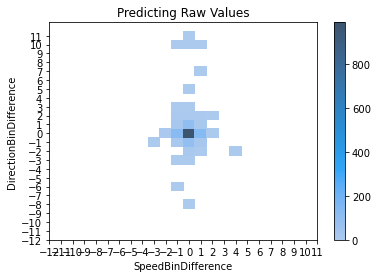

In [571]:
import seaborn as sns

g = sns.histplot(comp_2, x="SpeedBinDifference", y="DirectionBinDifference", discrete=True, cbar=True)
g.set_xticks(range(-12,12))#
g.set_yticks(range(-12,12))# <--- set the ticks first
g.set_title('Predicting Raw Values')

In [572]:
wrong = comp_2.query('DirectionBinEqual == False and SpeedBinEqual == False')

error = len(wrong) / comp_2.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
5.012690355329949


In [574]:
wrong = comp_2.query('DirectionBinEqual == False or SpeedBinEqual == False')

error = len(wrong) / comp_2.shape[0] * 100

print("Percentage of bins wrong:")
print(error)

Percentage of bins wrong:
37.119289340101524
